In [65]:
import torch
import numpy as np
from torch.utils.data import DataLoader,Subset
from torchvision import datasets, transforms
from pathlib import Path
from sklearn.model_selection import train_test_split
import shutil
import torch.nn as nn
from torchvision.models import resnet18,ResNet18_Weights
import os
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from sklearn.metrics import roc_curve, roc_auc_score





In [40]:
PATCH_SIZE = 128
BATCH_SIZE = 32
SEED = 42

PATCHES_ROOT = "patches_dataset/patches_v1_seed42"
np.random.seed(SEED)
torch.manual_seed(SEED)


In [52]:
# normalize helps with smoother gradient descent however TODO calculate own mean stf from own dataset
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize((PATCH_SIZE, PATCH_SIZE)),
    transforms.ToTensor(),
    normalize
])

full_ds = datasets.ImageFolder(root=PATCHES_ROOT)
print(f"total patches {len(full_ds)} class mapping {full_ds.class_to_idx} samples per class {np.bincount(full_ds.targets)}")


total patches 6117 class mapping {'negative': 0, 'positive': 1} samples per class [ 823 5294]


In [53]:
full_ds

Dataset ImageFolder
    Number of datapoints: 6117
    Root location: patches_dataset/patches_v1_seed42

In [54]:
# stratify bc the dataset is skewed more posititve, SEED for reproducability
train_idx, val_idx = train_test_split(range(len(full_ds)),test_size=0.2,stratify=full_ds.targets,random_state=SEED)
print(f"train {len(train_idx)} test {len(val_idx)}")


def create_split_folders(full_ds, train_idx, val_idx):
    base_path = Path("patches_split")
    
    for split_name, indices in [("train", train_idx), ("val", val_idx)]:
        split_path = base_path / split_name
        
        # Create positive/negative subfolders
        (split_path / "positive").mkdir(parents=True, exist_ok=True)
        (split_path / "negative").mkdir(parents=True, exist_ok=True)
        
        # Copy files
        for idx in indices:
            img_path, label = full_ds.samples[idx]
            class_name = full_ds.classes[label]  # 'negative' or 'positive'
            
            src = Path(img_path)
            dst = split_path / class_name / src.name
            
            if not dst.exists():  # Avoid duplicates
                shutil.copy2(src, dst)

create_split_folders(full_ds, train_idx, val_idx)
#train 4893 test 1224


train 4893 test 1224


In [55]:
train_ds = datasets.ImageFolder("patches_split/train", transform=transform)
val_ds = datasets.ImageFolder("patches_split/val", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4)



train_ds[0][0].shape, val_ds[0][0].shape


(torch.Size([3, 128, 128]), torch.Size([3, 128, 128]))

In [56]:
print(f"train loader {len(train_loader)} batces val_loader {len(val_loader)} batches")

train loader 153 batces val_loader 39 batches


In [57]:
images,labels = next(iter(train_loader))
images.shape,labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [74]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)

for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

print(f"Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


Trainable params: 1026


In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return val_loss/len(val_loader), correct/total


# Training loop
best_val_acc = 0
for epoch in range(10):
    model.train()
    train_loss, correct, total = 0, 0, 0
    
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc = correct / total
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    print(f'Epoch {epoch+1}: Train {train_acc:.3f}, Val {val_acc:.3f}')
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_resnet18.pt')

print(f"Best val accuracy: {best_val_acc:.3f}")

cpu


Epoch 1: 100%|██████████| 153/153 [01:39<00:00,  1.54it/s]


Epoch 1: Train 0.927, Val 0.973


Epoch 2: 100%|██████████| 153/153 [01:39<00:00,  1.54it/s]


Epoch 2: Train 0.969, Val 0.983


Epoch 3: 100%|██████████| 153/153 [01:39<00:00,  1.53it/s]


Epoch 3: Train 0.979, Val 0.984


Epoch 4: 100%|██████████| 153/153 [01:40<00:00,  1.53it/s]


Epoch 4: Train 0.975, Val 0.976


Epoch 5: 100%|██████████| 153/153 [01:40<00:00,  1.53it/s]


Epoch 5: Train 0.983, Val 0.984


Epoch 6: 100%|██████████| 153/153 [01:40<00:00,  1.53it/s]


Epoch 6: Train 0.984, Val 0.988


Epoch 7: 100%|██████████| 153/153 [01:40<00:00,  1.53it/s]


Epoch 7: Train 0.983, Val 0.986


Epoch 8: 100%|██████████| 153/153 [01:37<00:00,  1.57it/s]


Epoch 8: Train 0.984, Val 0.986


Epoch 9: 100%|██████████| 153/153 [01:40<00:00,  1.52it/s]


Epoch 9: Train 0.984, Val 0.985


Epoch 10: 100%|██████████| 153/153 [01:41<00:00,  1.51it/s]


Epoch 10: Train 0.985, Val 0.988
Best val accuracy: 0.988


In [66]:
def get_val_scores_and_labels(model, val_loader, device):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)                # shape: (B, 2)
            probs = torch.softmax(outputs, dim=1)  # logits to proba
            pos_probs = probs[:, 1]               # proba of positive class

            all_probs.append(pos_probs.cpu())
            all_labels.append(labels.cpu())

    all_probs = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()
    return all_probs, all_labels


In [75]:
model.load_state_dict(torch.load('best_resnet18.pt', map_location=device))

y_score, y_true = get_val_scores_and_labels(model, val_loader, device)


In [76]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)  # binary labels must be {0,1}

# AUROC
auc_score = roc_auc_score(y_true, y_score)
print(f"Validation AUROC: {auc_score:.4f}")


Validation AUROC: 0.9979


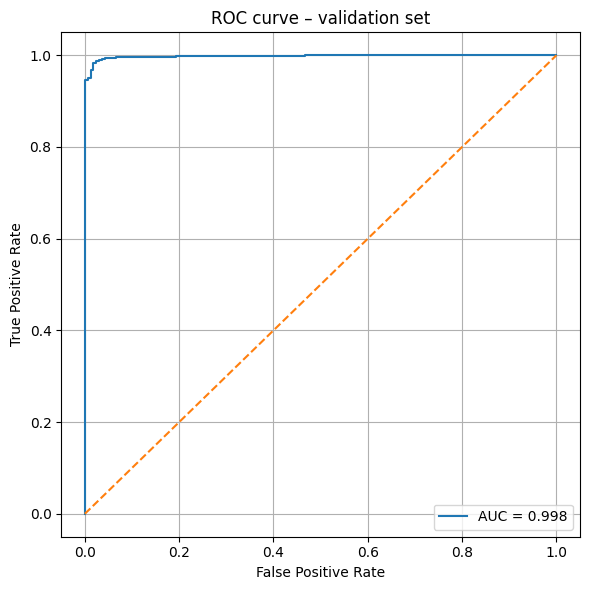

In [78]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve – validation set')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [79]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
vision_model.embeddings.position_ids | UNEXPECTED |  | 
text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [94]:
#imp = "patches_dataset/patches_v1_seed42/negative/817.png"
#imp = "patches_dataset/patches_v1_seed42/negative/0.png"
#imp = "patches_dataset/patches_v1_seed42/negative/49.png"
imp = "patches_dataset/patches_v1_seed42/negative/0.png"
image = Image.open(imp)
labels = [
    #"a tree",
    #"not a tree"
    "an aerial image of a patch of land without a tree",
    "an aerial image of a patch of land with a tree",
    #"an aerial image of a house",
    #"an areal image of a branch on the ground"
]

inputs = processor(text=labels, images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)
most_likely_idx = probs.argmax(dim=1).item()
most_likely_label = labels[most_likely_idx]
print(f"Most likely label: {most_likely_label} with probability: {probs[0][most_likely_idx].item():.3f}")


Most likely label: an aerial image of a patch of land without a tree with probability: 0.634
